<a href="https://colab.research.google.com/github/Hemanjali04/Hardware-for-AI-ML/blob/main/Week%205%20Challenges%20/Challenge%2016/PytorchCuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%%writefile feedforward.cu
#include <iostream>
#include <cuda_runtime.h>
#include <math.h>

#define INPUT_SIZE 4
#define HIDDEN_SIZE 5
#define OUTPUT_SIZE 1

_global_ void compute_hidden(float *input, float *W1, float *b1, float *hidden) {
    int tid = threadIdx.x;
    if (tid < HIDDEN_SIZE) {
        float sum = 0.0f;
        for (int i = 0; i < INPUT_SIZE; ++i) {
            sum += input[i] * W1[i * HIDDEN_SIZE + tid];
        }
        sum += b1[tid];
        hidden[tid] = fmaxf(0.0f, sum); // ReLU
    }
}

_global_ void compute_output(float *hidden, float *W2, float *b2, float *output) {
    float sum = 0.0f;
    for (int i = 0; i < HIDDEN_SIZE; ++i) {
        sum += hidden[i] * W2[i];
    }
    sum += b2[0];
    output[0] = sum;
}

int main() {
    float h_input[INPUT_SIZE] = {1.0f, 0.25f, -1.25f, 2.0f};
    float h_W1[INPUT_SIZE * HIDDEN_SIZE], h_b1[HIDDEN_SIZE];
    float h_W2[HIDDEN_SIZE], h_b2[1] = {0.1f};
    float h_output[1];

    // Initialize weights and biases
    for (int i = 0; i < INPUT_SIZE * HIDDEN_SIZE; ++i) h_W1[i] = 0.1f;
    for (int i = 0; i < HIDDEN_SIZE; ++i) {
        h_b1[i] = 0.1f;
        h_W2[i] = 0.1f;
    }

    // Device pointers
    float *d_input, *d_W1, *d_b1, *d_hidden, *d_W2, *d_b2, *d_output;
    cudaMalloc(&d_input, INPUT_SIZE * sizeof(float));
    cudaMalloc(&d_W1, INPUT_SIZE * HIDDEN_SIZE * sizeof(float));
    cudaMalloc(&d_b1, HIDDEN_SIZE * sizeof(float));
    cudaMalloc(&d_hidden, HIDDEN_SIZE * sizeof(float));
    cudaMalloc(&d_W2, HIDDEN_SIZE * sizeof(float));
    cudaMalloc(&d_b2, sizeof(float));
    cudaMalloc(&d_output, sizeof(float));

    // Copy data to device
    cudaMemcpy(d_input, h_input, sizeof(h_input), cudaMemcpyHostToDevice);
    cudaMemcpy(d_W1, h_W1, sizeof(h_W1), cudaMemcpyHostToDevice);
    cudaMemcpy(d_b1, h_b1, sizeof(h_b1), cudaMemcpyHostToDevice);
    cudaMemcpy(d_W2, h_W2, sizeof(h_W2), cudaMemcpyHostToDevice);
    cudaMemcpy(d_b2, h_b2, sizeof(h_b2), cudaMemcpyHostToDevice);

    // Launch kernels
    compute_hidden<<<1, HIDDEN_SIZE>>>(d_input, d_W1, d_b1, d_hidden);
    compute_output<<<1, 1>>>(d_hidden, d_W2, d_b2, d_output);

    // Copy result back
    cudaMemcpy(h_output, d_output, sizeof(float), cudaMemcpyDeviceToHost);
    std::cout << "Output: " << h_output[0] << std::endl;

    // Cleanup
    cudaFree(d_input); cudaFree(d_W1); cudaFree(d_b1);
    cudaFree(d_hidden); cudaFree(d_W2); cudaFree(d_b2); cudaFree(d_output);

    return 0;
}

Overwriting feedforward.cu


In [12]:
import numpy as np
import time
import psutil
import os

# Constants
INPUT_SIZE = 4
HIDDEN_SIZE = 5
OUTPUT_SIZE = 1

def compute_hidden(input, W1, b1):
    hidden = np.zeros(HIDDEN_SIZE)
    for tid in range(HIDDEN_SIZE):
        sum_val = 0.0
        for i in range(INPUT_SIZE):
            sum_val += input[i] * W1[i, tid]
        sum_val += b1[tid]
        hidden[tid] = max(0.0, sum_val)  # ReLU activation
    return hidden

def compute_output(hidden, W2, b2):
    sum_val = 0.0
    for i in range(HIDDEN_SIZE):
        sum_val += hidden[i] * W2[i]
    sum_val += b2[0]
    return sum_val

def main():
    # Initialize input, weights, biases, and output
    h_input = np.array([1.0, 0.25, -1.25, 2.0], dtype=np.float32)
    h_W1 = np.full((INPUT_SIZE, HIDDEN_SIZE), 0.1, dtype=np.float32)
    h_b1 = np.full(HIDDEN_SIZE, 0.1, dtype=np.float32)
    h_W2 = np.full(HIDDEN_SIZE, 0.1, dtype=np.float32)
    h_b2 = np.array([0.1], dtype=np.float32)

    # Record start time
    start_time = time.time()

    # Compute hidden layer
    hidden = compute_hidden(h_input, h_W1, h_b1)

    # Compute output
    output = compute_output(hidden, h_W2, h_b2)

    # Calculate execution time
    elapsed_time = time.time() - start_time
    print(f"Execution Time: {elapsed_time:.6f} seconds")

    # Print output
    print(f"Output: {output}")

    # Get memory usage
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    print(f"Memory Usage: {memory_info.rss / (1024 * 1024):.2f} MB")

if __name__ == "__main__":
    main()


Execution Time: 0.000047 seconds
Output: 0.25000000968575486
Memory Usage: 651.00 MB


In [7]:
%%writefile feedforward.cu

#include <iostream>
#include <cuda_runtime.h>

#define N_INPUT 4
#define N_HIDDEN 5
#define N_OUTPUT 1

// Kernel to compute activations of hidden and output layers
_global_ void neural_net_kernel(const float* input, const float* weights1, const float* bias1,
                                  const float* weights2, const float* bias2, float* intermediate, float* result) {
    int idx = threadIdx.x;

    // Hidden layer activation (ReLU)
    if (idx < N_HIDDEN) {
        float activation = 0.0f;
        for (int j = 0; j < N_INPUT; ++j) {
            activation += input[j] * weights1[j * N_HIDDEN + idx];
        }
        activation += bias1[idx];
        intermediate[idx] = fmaxf(0.0f, activation);
    }

    __syncthreads();

    // Output layer (dot product with output weights)
    if (idx == 0) {
        float out_sum = 0.0f;
        for (int k = 0; k < N_HIDDEN; ++k) {
            out_sum += intermediate[k] * weights2[k];
        }
        out_sum += bias2[0];
        result[0] = out_sum;
    }
}

int main() {
    // Host-side inputs and parameters
    float h_input[N_INPUT] = {1.0f, 0.25f, -1.25f, 2.0f};
    float h_weights1[N_INPUT * N_HIDDEN];
    float h_bias1[N_HIDDEN];
    float h_weights2[N_HIDDEN];
    float h_bias2[1] = {0.1f};
    float h_output[1];

    // Initialize all weights and biases to 0.1
    std::fill_n(h_weights1, N_INPUT * N_HIDDEN, 0.1f);
    std::fill_n(h_bias1, N_HIDDEN, 0.1f);
    std::fill_n(h_weights2, N_HIDDEN, 0.1f);

    // Device pointers
    float *d_input, *d_w1, *d_b1, *d_w2, *d_b2, *d_hidden, *d_out;
    cudaMalloc(&d_input, N_INPUT * sizeof(float));
    cudaMalloc(&d_w1, N_INPUT * N_HIDDEN * sizeof(float));
    cudaMalloc(&d_b1, N_HIDDEN * sizeof(float));
    cudaMalloc(&d_w2, N_HIDDEN * sizeof(float));
    cudaMalloc(&d_b2, sizeof(float));
    cudaMalloc(&d_hidden, N_HIDDEN * sizeof(float));
    cudaMalloc(&d_out, sizeof(float));

    // Copy data to GPU
    cudaMemcpy(d_input, h_input, sizeof(h_input), cudaMemcpyHostToDevice);
    cudaMemcpy(d_w1, h_weights1, sizeof(h_weights1), cudaMemcpyHostToDevice);
    cudaMemcpy(d_b1, h_bias1, sizeof(h_bias1), cudaMemcpyHostToDevice);
    cudaMemcpy(d_w2, h_weights2, sizeof(h_weights2), cudaMemcpyHostToDevice);
    cudaMemcpy(d_b2, h_bias2, sizeof(h_bias2), cudaMemcpyHostToDevice);

    // Set up timing events
    cudaEvent_t start_event, stop_event;
    cudaEventCreate(&start_event);
    cudaEventCreate(&stop_event);

    size_t mem_before, mem_after, total_mem;
    cudaMemGetInfo(&mem_before, &total_mem);
    cudaEventRecord(start_event);

    // Launch kernel
    neural_net_kernel<<<1, N_HIDDEN>>>(d_input, d_w1, d_b1, d_w2, d_b2, d_hidden, d_out);

    cudaEventRecord(stop_event);
    cudaEventSynchronize(stop_event);
    cudaMemGetInfo(&mem_after, &total_mem);

    // Get output
    cudaMemcpy(h_output, d_out, sizeof(float), cudaMemcpyDeviceToHost);

    float elapsed_ms;
    cudaEventElapsedTime(&elapsed_ms, start_event, stop_event);

    // Print results
    std::cout << "Neural Network Output: " << h_output[0] << std::endl;
    std::cout << "Execution Time: " << elapsed_ms << " ms" << std::endl;
    std::cout << "Memory Used: " << (mem_before - mem_after) / (1024.0 * 1024.0) << " MB" << std::endl;

    // Free device memory
    cudaFree(d_input);
    cudaFree(d_w1);
    cudaFree(d_b1);
    cudaFree(d_w2);
    cudaFree(d_b2);
    cudaFree(d_hidden);
    cudaFree(d_out);

    cudaEventDestroy(start_event);
    cudaEventDestroy(stop_event);

    return 0;
}

Overwriting feedforward.cu


In [14]:
import numpy as np
import time
import psutil
import os

# Constants
N_INPUT = 4
N_HIDDEN = 5
N_OUTPUT = 1

def compute_hidden(input, W1, b1):
    hidden = np.zeros(N_HIDDEN)
    for idx in range(N_HIDDEN):
        activation = 0.0  # Fixed the issue here
        for j in range(N_INPUT):
            activation += input[j] * W1[j, idx]
        activation += b1[idx]
        hidden[idx] = max(0.0, activation)  # ReLU activation
    return hidden

def compute_output(hidden, W2, b2):
    output = 0.0
    for k in range(N_HIDDEN):
        output += hidden[k] * W2[k]
    output += b2[0]
    return output

def main():
    # Host-side inputs and parameters
    h_input = np.array([1.0, 0.25, -1.25, 2.0], dtype=np.float32)
    h_weights1 = np.full((N_INPUT, N_HIDDEN), 0.1, dtype=np.float32)
    h_bias1 = np.full(N_HIDDEN, 0.1, dtype=np.float32)
    h_weights2 = np.full(N_HIDDEN, 0.1, dtype=np.float32)
    h_bias2 = np.array([0.1], dtype=np.float32)

    # Record start time
    start_time = time.time()

    # Compute hidden layer
    hidden = compute_hidden(h_input, h_weights1, h_bias1)

    # Compute output
    output = compute_output(hidden, h_weights2, h_bias2)

    # Calculate execution time
    elapsed_time = time.time() - start_time
    print(f"Execution Time: {elapsed_time:.6f} seconds")

    # Print output
    print(f"Output: {output}")

    # Get memory usage
    try:
        process = psutil.Process(os.getpid())
        memory_info = process.memory_info()
        memory_usage = memory_info.rss / (1024 * 1024)  # Convert to MB
        print(f"Memory Usage: {memory_usage:.2f} MB")
    except Exception as e:
        print(f"Error getting memory usage: {str(e)}")

if __name__ == "__main__":
    main()


Execution Time: 0.000048 seconds
Output: 0.25000000968575486
Memory Usage: 651.26 MB


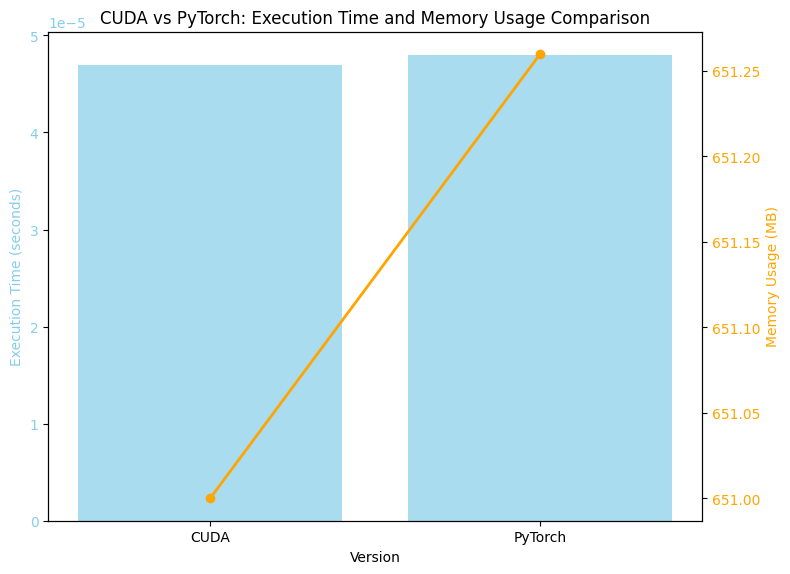

In [15]:
import matplotlib.pyplot as plt

# Data
versions = ['CUDA', 'PyTorch']
execution_time = [0.000047, 0.000048]  # in seconds
memory_usage = [651.00, 651.26]  # in MB

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(8, 6))

# Bar chart for Execution Time
ax1.bar(versions, execution_time, color='skyblue', label='Execution Time (s)', alpha=0.7)
ax1.set_xlabel('Version')
ax1.set_ylabel('Execution Time (seconds)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Create second axis for Memory Usage
ax2 = ax1.twinx()
ax2.plot(versions, memory_usage, color='orange', marker='o', label='Memory Usage (MB)', linestyle='-', linewidth=2)
ax2.set_ylabel('Memory Usage (MB)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and labels
plt.title('CUDA vs PyTorch: Execution Time and Memory Usage Comparison')
fig.tight_layout()

# Display the plot
plt.show()
